In [1]:
import sys
sys.path.append('../code/')

# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import pacf, acf
from arch import arch_model

from preprocessing_utils import preprocess_df
from plot_utils import plot_store_charts, plot_folds
from test_utils import run_stat_test
from sm_utils import compute_pacf_acf, StatmodelsWrapper, run_k_fold_tain_val_statmodels
from metrics import mean_absolute_error, rmse, rss, r2_score, durbin_watson

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# Load Data

In [2]:
ts = pd.read_csv('../data/US1.NVDA_200101_210215.csv', delimiter=';')
ts = preprocess_df(ts)
ts

,ticker,per,date,time,open,high,low,close,vol,Nclose
0,US1.NVDA,D,2020-01-02,0,238.85,239.88,236.73,239.79,303428,0.392886
1,US1.NVDA,D,2020-01-03,0,234.65,237.81,234.17,236.37,268936,0.387282
2,US1.NVDA,D,2020-01-06,0,232.21,237.25,231.52,237.07,432624,0.388429
3,US1.NVDA,D,2020-01-07,0,238.03,241.76,236.39,239.83,576787,0.392951
4,US1.NVDA,D,2020-01-08,0,239.65,242.04,238.15,240.42,540373,0.393918
...,...,...,...,...,...,...,...,...,...,...
275,US1.NVDA,D,2021-02-08,0,549.96,578.93,549.96,577.70,316219,0.946537
276,US1.NVDA,D,2021-02-09,0,574.02,583.00,568.90,570.35,142242,0.934494
277,US1.NVDA,D,2021-02-10,0,579.02,596.20,574.45,590.72,320581,0.967870
278,US1.NVDA,D,2021-02-11,0,599.50,610.89,597.61,610.33,268265,1.000000


# Train/Test splitting

In [3]:
test_file_period = 7
train_file_period = ts['date'].max() - ts['date'].min()
print(f"Test file period {test_file_period}\nTrain file period {train_file_period}")

Test file period 7
Train file period 407 days 00:00:00


In [4]:
fold_ids = list(TimeSeriesSplit(test_size=test_file_period).split(ts))

# Trim start in order to have same size folds
train_fold_len = min([len(el[0]) for el in fold_ids])
for i in range(len(fold_ids)):
    fold_ids[i] = (fold_ids[i][0][-train_fold_len:], fold_ids[i][1])

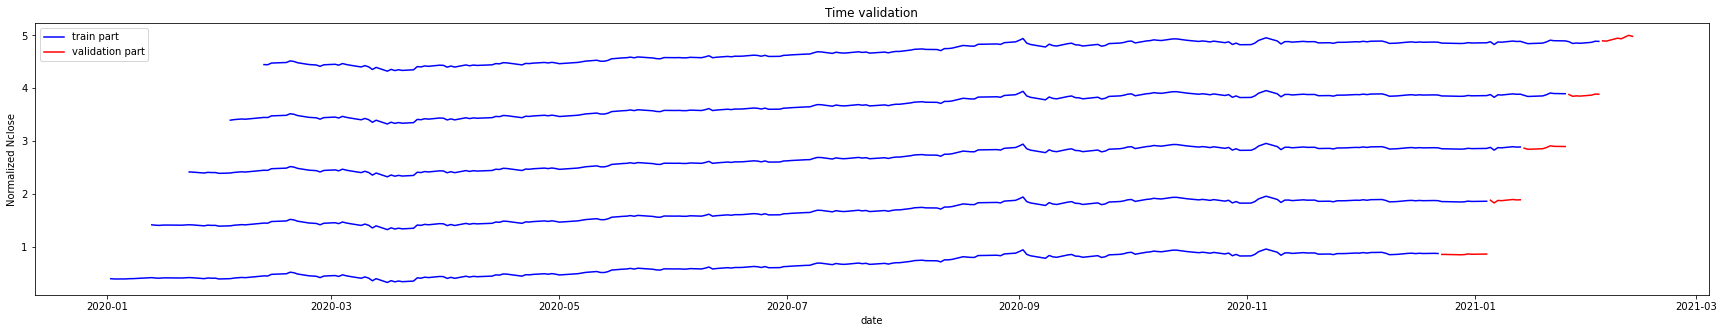

In [5]:
plot_folds(ts, fold_ids)

# Modelling

In [6]:
def compute_metrics(y_pred, y_true):
    print('RMSE: %.4f'% np.sqrt(sum((y_pred-y_true)**2)/len(y_true)))
    print('RSS: %.4f'% sum((y_pred-y_true.values)**2))
    print ('r2_score: %.4f' %r2_score(y_true, y_pred))
    print ('durbin_watson score: %.4f' %durbin_watson(np.abs(y_pred - y_true)))
    
def dima_reversed_partial(time_s, preds):
    time_s = np.log1p(time_s)
    time_s_diff_1 = time_s.diff(1).dropna().reset_index(drop=True)
    time_s_diff_1_from_pred = time_s_diff_1.shift(1).dropna().reset_index(drop=True) + preds
    log_result = time_s.shift(1).dropna().reset_index(drop=True) + time_s_diff_1_from_pred
    return np.expm1(log_result)

def dima_stationary(input):
    return np.log1p(input).diff(2).dropna().reset_index(drop=True)

In [7]:
y_true_all = np.log1p(ts['close']).diff(periods=2).dropna().reset_index(drop=True)
# y_true = dima_stationary(train_fold_1['close'])

y_true = y_true_all.iloc[:-7]
y_tru_val = y_true_all.iloc[-7:]

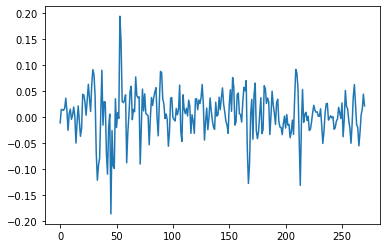

In [8]:
plt.plot(y_true)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


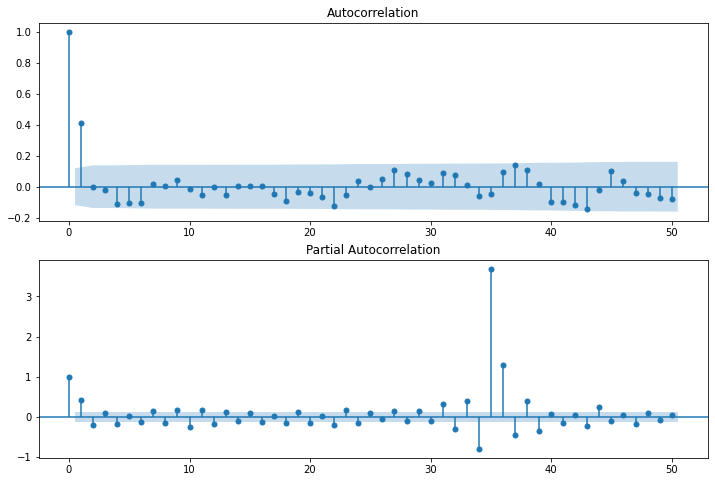

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_true, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_true, lags=50, ax=ax2)
plt.show()

In [10]:
ARIMA_m = ARIMA(y_true, order=(40,0,0))

ARIMA_m = ARIMA_m.fit()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
ARIMA_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  271
Model:                ARIMA(40, 0, 0)   Log Likelihood                 553.589
Date:                Mon, 22 Mar 2021   AIC                          -1023.178
Time:                        12:03:42   BIC                           -871.889
Sample:                             0   HQIC                          -962.434
                                - 271                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.003      1.930      0.054   -9.36e-05       0.012
ar.L1          0.7273      0.061     11.907      0.000       0.608       0.847
ar.L2         -0.6414      0.072     -8.865      0.000      -0.783      -0.500
ar.L3          0.6620      0.096      6.861      0.000       0.473       0.851
ar.L4         -0.7354      0.115     -6.418      0.000      -0.960      -0.511
ar.L5          0.6533      0.127      5.139      0.000       0.404       0.902
ar.L6         -0.7994      0.115     -6.952      0.000      -1.025      -0.574
ar.L7          0.8373      0.139      6.044      0.000       0.566       1.109
ar.L8         -0.8556      0.135     -6.340      0.000      -1.120      -0.591
ar.L9          0.9099      0.154      5.907      0.000       0.608       1.212
ar.L10        -0.9032      0.171     -5.287      0.000      -1.238      -0.568
ar.L11         0.8048      0.189      4.263      0.000       0.435       1.175
ar.L12        -0.7564      0.194     -3.897      0.000      -1.137      -0.376
ar.L13         0.6877      0.204      3.364      0.001       0.287       1.088
ar.L14        -0.6105      0.210     -2.913      0.004      -1.021      -0.200
ar.L15         0.5899      0.224      2.636      0.008       0.151       1.028
ar.L16        -0.5343      0.221     -2.416      0.016      -0.968      -0.101
ar.L17         0.4432      0.237      1.870      0.062      -0.021       0.908
ar.L18        -0.5040      0.238     -2.120      0.034      -0.970      -0.038
ar.L19         0.4327      0.232      1.861      0.063      -0.023       0.888
ar.L20        -0.3779      0.238     -1.587      0.113      -0.845       0.089
ar.L21         0.3084      0.238      1.296      0.195      -0.158       0.775
ar.L22        -0.4011      0.238     -1.685      0.092      -0.868       0.065
ar.L23         0.2821      0.231      1.223      0.221      -0.170       0.734
ar.L24        -0.2187      0.233     -0.937      0.349      -0.676       0.239
ar.L25         0.1807      0.222      0.814      0.416      -0.254       0.616
ar.L26        -0.1501      0.209     -0.717      0.474      -0.561       0.260
ar.L27         0.2122      0.214      0.991      0.322      -0.207       0.632
ar.L28        -0.1598      0.203     -0.786      0.432      -0.558       0.238
ar.L29         0.1573      0.207      0.760      0.448      -0.249       0.563
ar.L30        -0.1606      0.192     -0.838      0.402      -0.536       0.215
ar.L31         0.2317      0.188      1.234      0.217      -0.136       0.600
ar.L32        -0.0946      0.177     -0.533      0.594      -0.442       0.253
ar.L33         0.1168      0.161      0.727      0.467      -0.198       0.432
ar.L34        -0.1315      0.155     -0.847      0.397      -0.436       0.173
ar.L35         0.0333      0.143      0.233      0.816      -0.247       0.313
ar.L36         0.0341      0.125      0.274      0.784      -0.210       0.278
ar.L37         0.1154      0.115      1.005      0.315      -0.110       0.340
ar

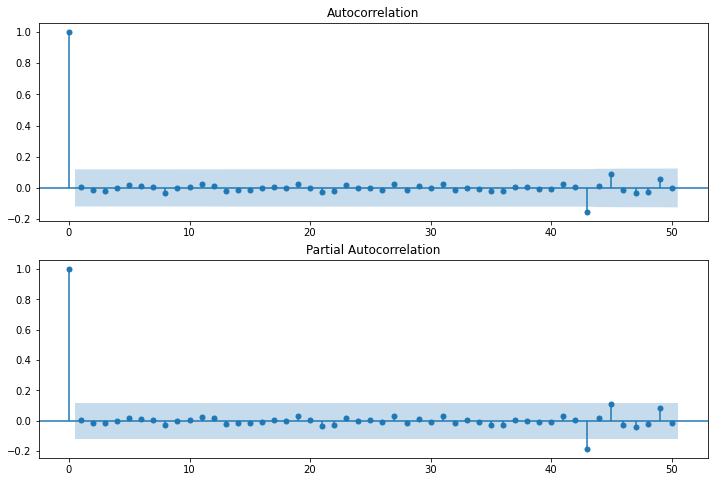

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ARIMA_m.resid, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ARIMA_m.resid, lags=50, ax=ax2)
plt.show()

In [13]:
ARIMA_m = ARIMA(y_true, order=(40,0,44))

ARIMA_m = ARIMA_m.fit()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


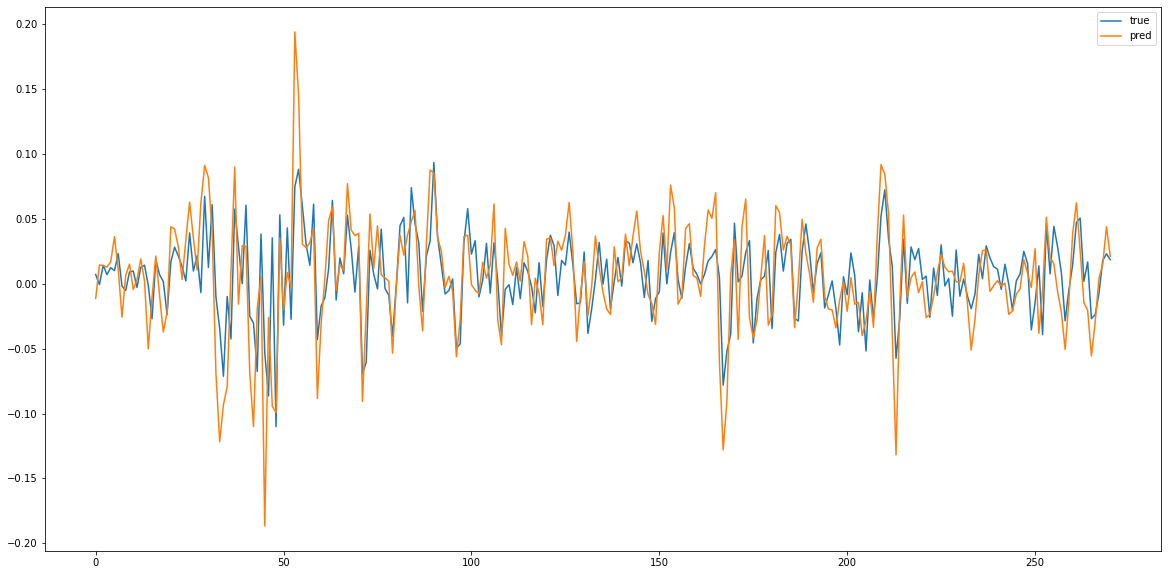

RMSE: 0.0300
RSS: 0.2445
r2_score: 0.5049
durbin_watson score: 0.6222


In [14]:
plt.figure(figsize=(20,10))
plt.plot(ARIMA_m.fittedvalues, label='true')
plt.plot(y_true, label='pred')
plt.legend()
plt.show()

compute_metrics(ARIMA_m.fittedvalues, y_true)

In [15]:
arima_pred = ARIMA_m.fittedvalues
arima_res = ARIMA_m.resid

In [16]:
arima_pred

0      0.007115
1     -0.000665
2      0.014304
3      0.007012
4      0.012399
         ...   
266   -0.023852
267   -0.007545
268    0.017850
269    0.023065
270    0.018556
Length: 271, dtype: float64

In [17]:
arch_m = arch_model(arima_res, mean='HARX', lags=100, vol='ARCH', p=32) 
arch_m = arch_m.fit(update_freq=0)
arch_m.summary()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003488. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -458.78521949233766
            Iterations: 27
            Function evaluations: 3162
            Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                           HAR - ARCH Model Results                           
==============================================================================
Dep. Variable:                   None   R-squared:                       0.355
Mean Model:                       HAR   Adj. R-squared:                 -0.567
Vol Model:                       ARCH   Log-Likelihood:                458.785
Distribution:                  Normal   AIC:                          -649.570
Method:            Maximum Likelihood   BIC:                          -228.588
                                        No. Observations:                  171
Date:                Mon, Mar 22 2021   Df Residuals:                       70
Time:                        12:05:35   Df Model:                          101
                                   Mean Model                                  
===============================================================================
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const       -3.4433e-04  1.222e-02 -2.819e-02      0.978 [-2.429e-02,2.360e-02]
None[0:1]        0.2029      0.417      0.487      0.627      [ -0.614,  1.020]
None[0:2]       -0.2261      0.404     -0.560      0.575      [ -1.017,  0.565]
None[0:3]        0.0740      0.634      0.117      0.907      [ -1.169,  1.317]
None[0:4]       -0.1653      1.128     -0.147      0.883      [ -2.376,  2.045]
None[0:5]       -1.3224      1.395     -0.948      0.343      [ -4.057,  1.412]
None[0:6]        2.1297      2.530      0.842      0.400      [ -2.829,  7.089]
None[0:7]       -2.1440      1.611     -1.331      0.183      [ -5.302,  1.014]
None[0:8]        1.7324      1.340      1.293      0.196      [ -0.894,  4.359]
None[0:9]       -0.5127      1.571     -0.326      0.744      [ -3.592,  2.567]
None[0:10]       0.0509      3.174  1.604e-02      0.987      [ -6.170,  6.272]
None[0:11]      -0.8470      3.498     -0.242      0.809      [ -7.703,  6.009]
None[0:12]       0.3043      3.603  8.446e-02      0.933      [ -6.757,  7.366]
None[0:13]       3.4196      6.874      0.497      0.619      [-10.053, 16.892]
None[0:14]      -2.1512      5.379     -0.400      0.689      [-12.695,  8.392]
None[0:15]      -0.4067      7.433 -5.472e-02      0.956      [-14.976, 14.162]
None[0:16]      -0.0456      4.350 -1.049e-02      0.992      [ -8.572,  8.480]
None[0:17]      -0.1355      6.189 -2.189e-02      0.983      [-12.266, 11.995]
None[0:18]      -2.3564      7.676     -0.307      0.759      [-17.402, 12.689]
None[0:19]      -4.1114     10.924     -0.376      0.707      [-25.522, 17.299]
None[0:20]       3.8027      7.219      0.527      0.598      [-10.347, 17.952]
None[0:21]       0.4050      8.077  5.014e-02      0.960      [-15.426, 16.236]
None[0:22]       0.7473      7.636  9.787e-02      0.922      [-14.219, 15.714]
None[0:23]       3.1327      7.489      0.418      0.676      [-11.546, 17.811]
None[0:24]      -2.3825      8.122     -0.293      0.769      [-18.302, 13.536]
None[0:25]       3.2359      6.711      0.482      0.630      [ -9.918, 16.390]
None[0:26]      -3.9397      4.945     -0.797      0.426      [-13.632,  5.752]
None[0:27]       2.5949     10.296      0.252      0.801      [-17.585, 22.774]
None[0:28]      -0.6110     11.406 -5.357e-02      0.957      [-22.966, 21.744]
None[0:29]      -2.8963     17.974     -0.161      0.872      [-38.124, 32.332]
None[0:30]       4.5565     15.724      0.290      0.772      [-26.263, 35.376]
None[0:31]      -2.2463     15.920     -0.141      0.888      [-33.449, 28.956]
None[0:32]       1.0057     13.438  7.484e-02      0.940      [-25.332, 27.343]
None[0:33]      -6.9176      7.867     -0.879      0.379      [-22.337,  8.502]
None[0:34]       7.3680     12.819      0.575      0.565      [-17.758, 32.494]
None[0:35]      -4.1921     10.841     -0.

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

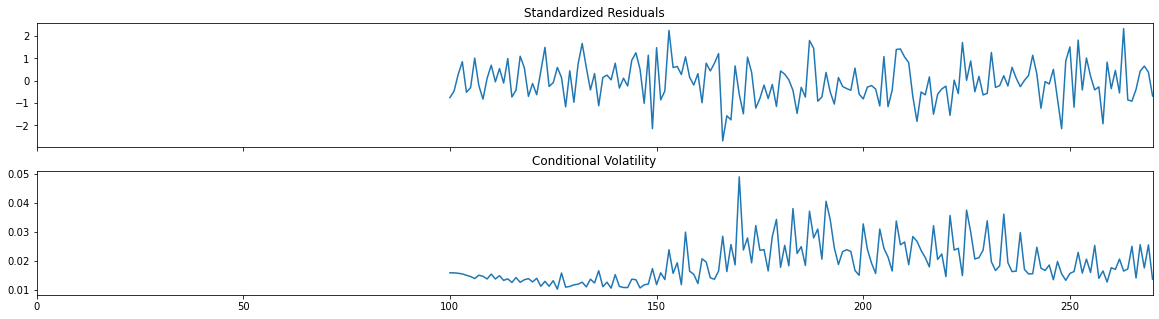

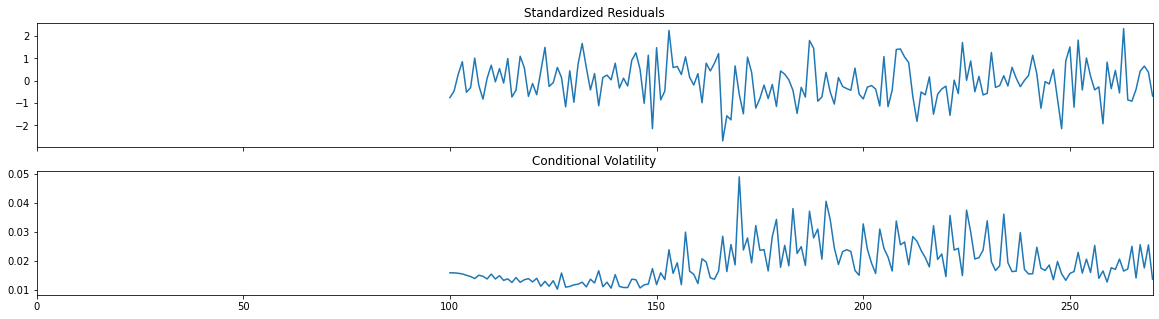

In [19]:
arch_m.plot()

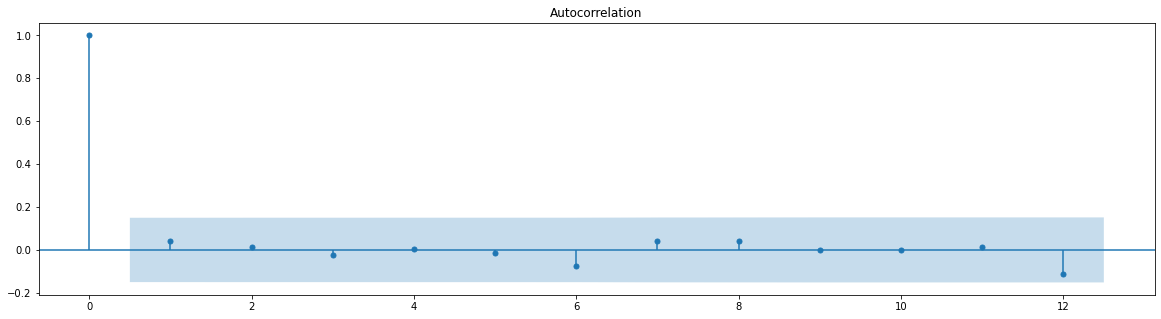

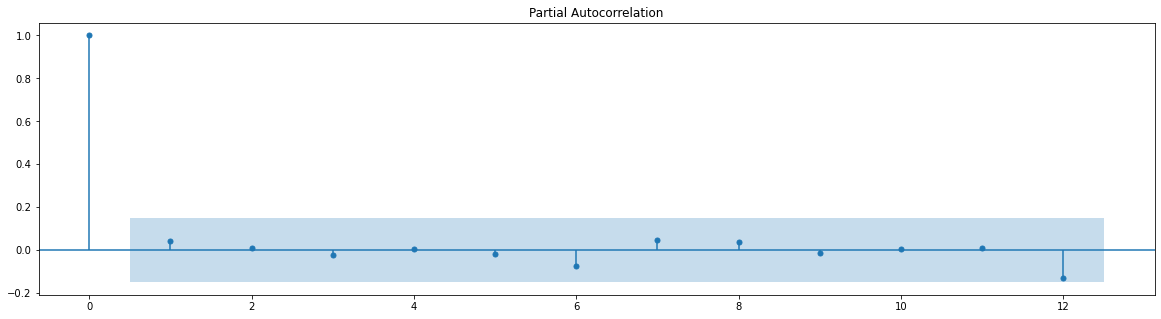

In [20]:
fig1 = sm.graphics.tsa.plot_acf(arch_m.resid.dropna().values, lags=12)
fig2 = sm.graphics.tsa.plot_pacf(arch_m.resid.dropna().values, lags=12)
plt.show()

In [21]:
garch_m = arch_model(arima_res, mean='HARX', lags=100, vol='GARCH', p=20, q=1)
garch_m = garch_m.fit(update_freq=0)
garch_m.summary()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003488. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -443.7429733457493
            Iterations: 23
            Function evaluations: 2425
            Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                          HAR - GARCH Model Results                           
==============================================================================
Dep. Variable:                   None   R-squared:                       0.422
Mean Model:                       HAR   Adj. R-squared:                 -0.405
Vol Model:                      GARCH   Log-Likelihood:                443.743
Distribution:                  Normal   AIC:                          -641.486
Method:            Maximum Likelihood   BIC:                          -255.061
                                        No. Observations:                  171
Date:                Mon, Mar 22 2021   Df Residuals:                       70
Time:                        12:05:42   Df Model:                          101
                                   Mean Model                                  
===============================================================================
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const       -1.4778e-03  5.828e-03     -0.254      0.800 [-1.290e-02,9.946e-03]
None[0:1]        0.1808      0.355      0.510      0.610      [ -0.514,  0.876]
None[0:2]       -0.1530      0.256     -0.597      0.550      [ -0.655,  0.349]
None[0:3]        0.0995      0.951      0.105      0.917      [ -1.764,  1.963]
None[0:4]       -0.3218      0.892     -0.361      0.718      [ -2.070,  1.426]
None[0:5]       -0.8422      0.975     -0.864      0.388      [ -2.753,  1.068]
None[0:6]        1.5129      0.740      2.044  4.096e-02    [6.213e-02,  2.964]
None[0:7]       -1.7973      2.079     -0.865      0.387      [ -5.872,  2.277]
None[0:8]        1.3053      2.460      0.531      0.596      [ -3.516,  6.127]
None[0:9]       -0.0162      1.485 -1.089e-02      0.991      [ -2.926,  2.893]
None[0:10]       0.0781      1.694  4.610e-02      0.963      [ -3.243,  3.399]
None[0:11]      -0.2554      2.280     -0.112      0.911      [ -4.725,  4.214]
None[0:12]       0.0520      9.650  5.385e-03      0.996      [-18.861, 18.965]
None[0:13]       2.7212     10.148      0.268      0.789      [-17.168, 22.610]
None[0:14]      -2.8034      3.093     -0.906      0.365      [ -8.866,  3.259]
None[0:15]       0.8225      5.134      0.160      0.873      [ -9.239, 10.884]
None[0:16]      -0.6999      7.630 -9.174e-02      0.927      [-15.653, 14.254]
None[0:17]      -0.8769      3.533     -0.248      0.804      [ -7.802,  6.048]
None[0:18]      -1.7713      3.524     -0.503      0.615      [ -8.678,  5.135]
None[0:19]      -2.5080      3.927     -0.639      0.523      [-10.205,  5.189]
None[0:20]       2.9986     11.135      0.269      0.788      [-18.826, 24.823]
None[0:21]      -0.8489     16.693 -5.085e-02      0.959      [-33.566, 31.868]
None[0:22]       0.8650      6.201      0.140      0.889      [-11.288, 13.018]
None[0:23]       2.8720     11.517      0.249      0.803      [-19.702, 25.446]
None[0:24]      -2.0634      7.390     -0.279      0.780      [-16.547, 12.420]
None[0:25]       3.5939      9.287      0.387      0.699      [-14.608, 21.796]
None[0:26]      -4.1863      9.929     -0.422      0.673      [-23.646, 15.274]
None[0:27]       2.7809      7.335      0.379      0.705      [-11.595, 17.157]
None[0:28]      -0.4220     13.295 -3.174e-02      0.975      [-26.480, 25.636]
None[0:29]      -3.9814     22.229     -0.179      0.858      [-47.549, 39.586]
None[0:30]       5.1501      9.998      0.515      0.606      [-14.445, 24.746]
None[0:31]      -2.8117     13.645     -0.206      0.837      [-29.555, 23.932]
None[0:32]       0.8155      5.393      0.151      0.880      [ -9.755, 11.386]
None[0:33]      -6.6303      7.304     -0.908      0.364      [-20.947,  7.686]
None[0:34]       7.9890     12.619      0.633      0.527      [-16.744, 32.722]
None[0:35]      -4.5497      6.222     -0.

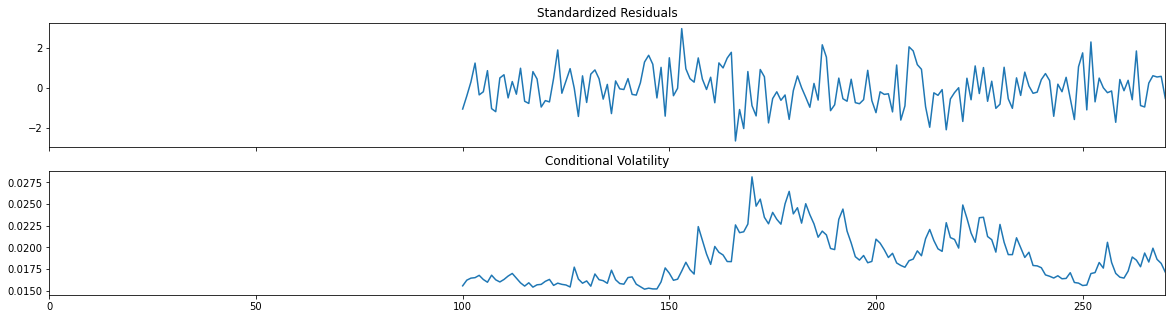

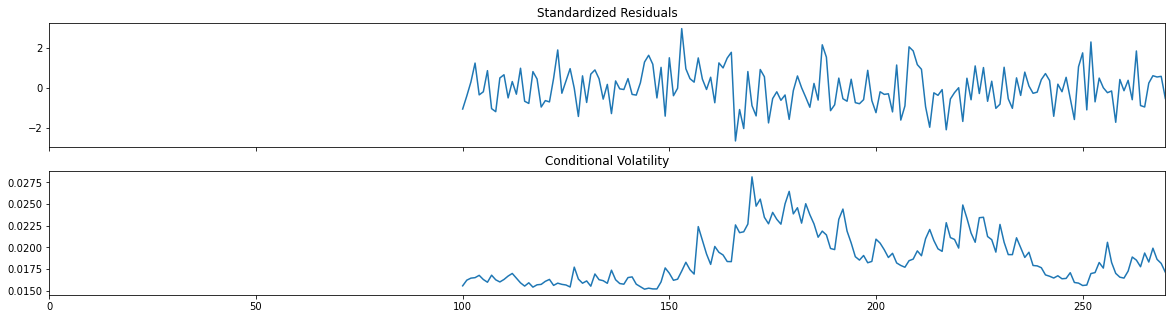

In [22]:
garch_m.plot()

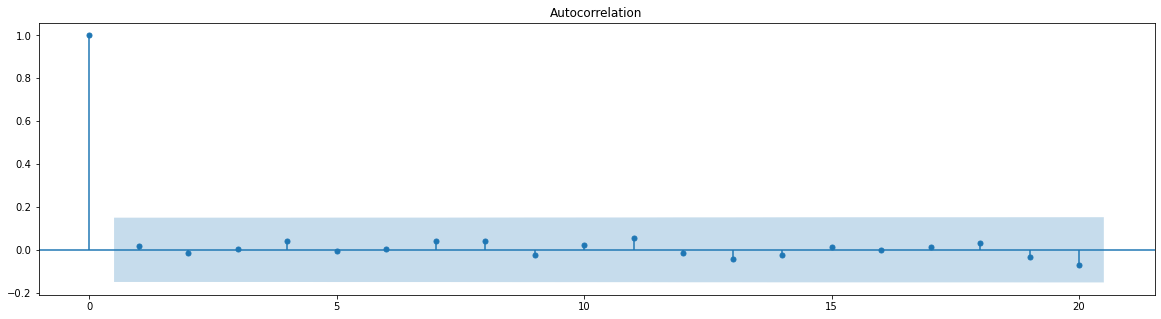

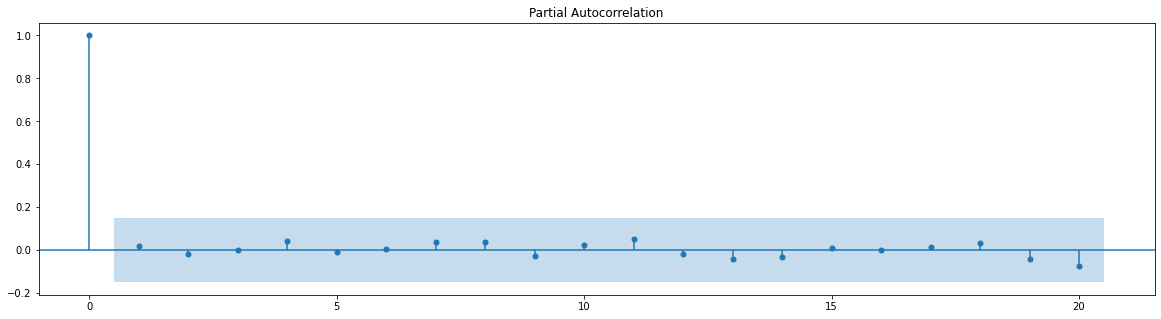

In [23]:
fig1 = sm.graphics.tsa.plot_acf(garch_m.resid.dropna().values.squeeze(), lags=20)
fig2 = sm.graphics.tsa.plot_pacf(garch_m.resid.dropna().values.squeeze(), lags=20)
plt.show()

In [24]:
figarch_m = arch_model(arima_res, mean='HARX', lags=100, vol='FIGARCH', p=1, q=1)
figarch_m = figarch_m.fit(update_freq=0)
figarch_m.summary()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003488. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -482.923168863663
            Iterations: 35
            Function evaluations: 3339
            Gradient evaluations: 31


<class 'statsmodels.iolib.summary.Summary'>
"""
                         HAR - FIGARCH Model Results                          
==============================================================================
Dep. Variable:                   None   R-squared:                       0.058
Mean Model:                       HAR   Adj. R-squared:                 -1.288
Vol Model:                    FIGARCH   Log-Likelihood:                482.923
Distribution:                  Normal   AIC:                          -755.846
Method:            Maximum Likelihood   BIC:                          -425.972
                                        No. Observations:                  171
Date:                Mon, Mar 22 2021   Df Residuals:                       70
Time:                        12:05:49   Df Model:                          101
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       1.9134e-03  1.654e-02      0.116      0.908 [-3.051e-02,3.434e-02]
None[0:1]   3.5071e-03      1.508  2.325e-03      0.998      [ -2.953,  2.960]
None[0:2]      -0.3437      1.254     -0.274      0.784      [ -2.801,  2.114]
None[0:3]      -0.4014      1.432     -0.280      0.779      [ -3.208,  2.405]
None[0:4]       0.3843      1.724      0.223      0.824      [ -2.995,  3.763]
None[0:5]      -1.2203      1.850     -0.660      0.510      [ -4.847,  2.406]
None[0:6]       1.9734      1.823      1.083      0.279      [ -1.599,  5.546]
None[0:7]      -1.5987      6.317     -0.253      0.800      [-13.981, 10.783]
None[0:8]       0.4608      5.639  8.171e-02      0.935      [-10.592, 11.514]
None[0:9]       1.8333      5.081      0.361      0.718      [ -8.126, 11.792]
None[0:10]     -0.6408     10.063 -6.368e-02      0.949      [-20.365, 19.083]
None[0:11]      0.2598     12.849  2.022e-02      0.984      [-24.924, 25.443]
None[0:12]     -0.8000      3.249     -0.246      0.805      [ -7.167,  5.567]
None[0:13]      1.6794      6.697      0.251      0.802      [-11.446, 14.805]
None[0:14]     -0.4863      5.091 -9.551e-02      0.924      [-10.465,  9.493]
None[0:15]     -1.4114     16.688 -8.458e-02      0.933      [-34.120, 31.297]
None[0:16]      0.3896     26.922  1.447e-02      0.988      [-52.376, 53.155]
None[0:17]     -2.0315     18.401     -0.110      0.912      [-38.097, 34.034]
None[0:18]     -0.4182     16.324 -2.562e-02      0.980      [-32.412, 31.576]
None[0:19]     -4.4015     18.849     -0.234      0.815      [-41.344, 32.542]
None[0:20]      5.2614     11.198      0.470      0.638      [-16.686, 27.209]
None[0:21]      0.6152     20.560  2.992e-02      0.976      [-39.681, 40.912]
None[0:22]      0.5053     26.601  1.899e-02      0.985      [-51.631, 52.642]
None[0:23]      5.2680     14.257      0.370      0.712      [-22.675, 33.211]
None[0:24]     -4.0791     17.524     -0.233      0.816      [-38.426, 30.267]
None[0:25]      2.7764     22.921      0.121      0.904      [-42.147, 47.700]
None[0:26]     -5.0922     11.222     -0.454      0.650      [-27.087, 16.903]
None[0:27]      4.1746      9.346      0.447      0.655      [-14.142, 22.491]
None[0:28]     -4.9928     11.828     -0.422      0.673      [-28.175, 18.189]
None[0:29]     -2.3465     38.979 -6.020e-02      0.952      [-78.744, 74.051]
None[0:30]      4.5890     10.089      0.455      0.649      [-15.184, 24.362]
None[0:31]      0.5954     45.823  1.299e-02      0.990      [-89.215, 90.406]
None[0:32]      0.2799     20.297  1.379e-02      0.989      [-39.501, 40.061]
None[0:33]     -7.6101     19.384     -0.393      0.695      [-45.602, 30.382]
None[0:34]      7.4017     31.248      0.237      0.813      [-53.843, 68.646]
None[0:35]     -1.0909     10.508     -0.104      0.917      [-21.686, 19.505]
No

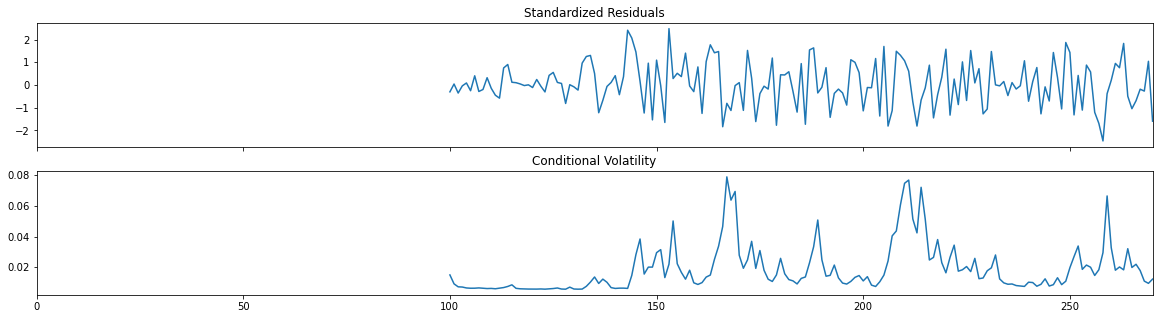

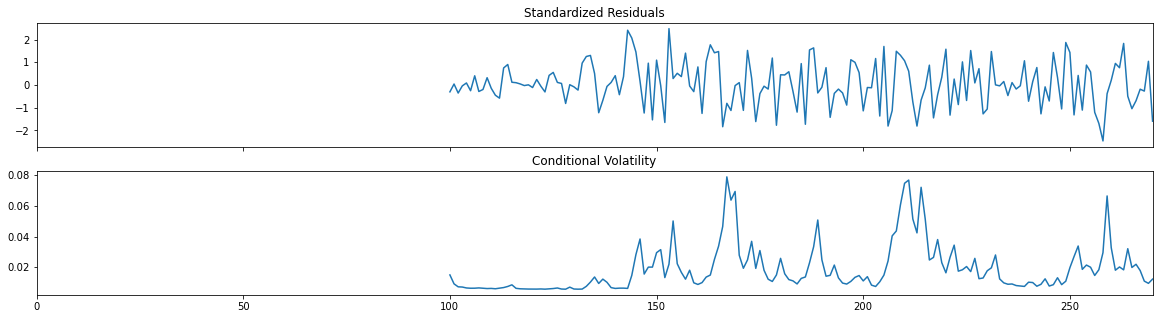

In [25]:
figarch_m.plot()

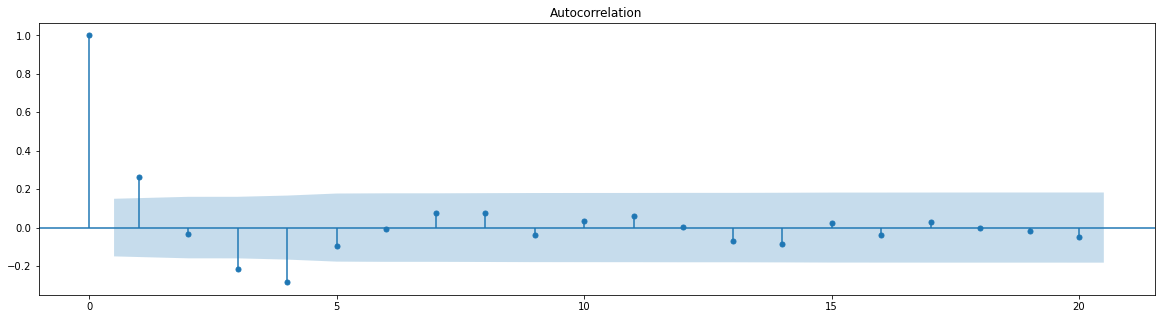

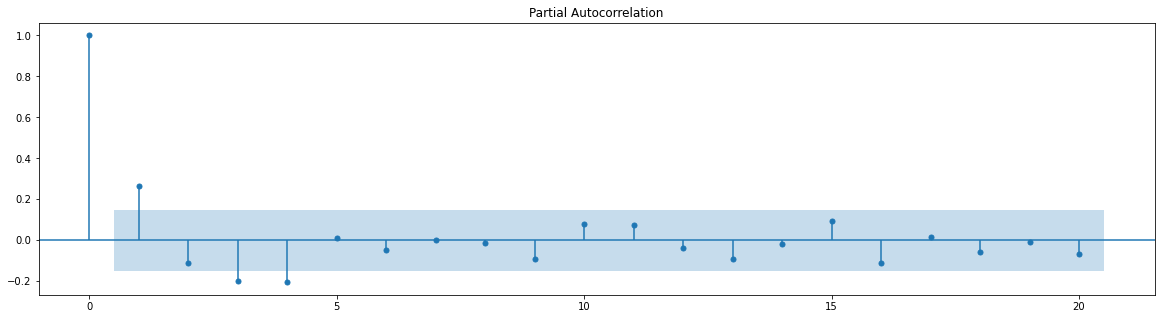

In [26]:
fig = sm.graphics.tsa.plot_acf(figarch_m.resid.dropna().values.squeeze(), lags=20)
fig1 = sm.graphics.tsa.plot_pacf(figarch_m.resid.dropna().values.squeeze(), lags=20)
plt.show()

In [27]:
egarch_m = arch_model(arima_res, mean='HARX', lags=100, vol='EGARCH', p=20, q=1, )
egarch_m = egarch_m.fit(update_freq=0)
egarch_m.summary()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003488. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code

Iteration limit reached    (Exit mode 9)
            Current function value: -518.331151989738
            Iterations: 100
            Function evaluations: 12619
            Gradient evaluations: 99


<class 'statsmodels.iolib.summary.Summary'>
"""
                          HAR - EGARCH Model Results                          
==============================================================================
Dep. Variable:                   None   R-squared:                       0.224
Mean Model:                       HAR   Adj. R-squared:                 -0.884
Vol Model:                     EGARCH   Log-Likelihood:                518.331
Distribution:                  Normal   AIC:                          -790.662
Method:            Maximum Likelihood   BIC:                          -404.238
                                        No. Observations:                  171
Date:                Mon, Mar 22 2021   Df Residuals:                       70
Time:                        12:05:58   Df Model:                          101
                                   Mean Model                                   
================================================================================
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const       -1.8269e-03  1.281e-04    -14.260  3.862e-46 [-2.078e-03,-1.576e-03]
None[0:1]        0.1613      0.397      0.407      0.684       [ -0.616,  0.939]
None[0:2]       -0.2432  3.916e-02     -6.210  5.295e-10       [ -0.320, -0.166]
None[0:3]        0.5108      0.113      4.540  5.636e-06       [  0.290,  0.731]
None[0:4]       -0.6812      0.108     -6.307  2.842e-10       [ -0.893, -0.470]
None[0:5]       -1.3262      0.387     -3.425  6.146e-04       [ -2.085, -0.567]
None[0:6]        2.0628  3.209e-03    642.826      0.000       [  2.057,  2.069]
None[0:7]       -2.3767  6.059e-02    -39.224      0.000       [ -2.495, -2.258]
None[0:8]        1.4758      2.684      0.550      0.582       [ -3.785,  6.737]
None[0:9]       -0.2173      9.471 -2.294e-02      0.982       [-18.780, 18.345]
None[0:10]      -0.3569     11.323 -3.152e-02      0.975       [-22.550, 21.836]
None[0:11]      -0.8593      1.932     -0.445      0.656       [ -4.646,  2.927]
None[0:12]       1.1066      5.842      0.189      0.850       [-10.344, 12.557]
None[0:13]       3.1702      0.282     11.241  2.576e-29       [  2.617,  3.723]
None[0:14]      -2.7179      1.013     -2.682  7.313e-03       [ -4.704, -0.732]
None[0:15]      -0.3131      2.044     -0.153      0.878       [ -4.319,  3.693]
None[0:16]      -0.3256      2.017     -0.161      0.872       [ -4.279,  3.628]
None[0:17]      -0.3965      2.366     -0.168      0.867       [ -5.034,  4.241]
None[0:18]      -1.2960      2.888     -0.449      0.654       [ -6.956,  4.364]
None[0:19]      -3.4724      0.157    -22.109 2.612e-108       [ -3.780, -3.165]
None[0:20]       3.4739      0.308     11.287  1.523e-29       [  2.871,  4.077]
None[0:21]      -0.6269      8.858 -7.077e-02      0.944       [-17.988, 16.735]
None[0:22]       1.8688      0.214      8.728  2.594e-18       [  1.449,  2.288]
None[0:23]       3.4314      0.378      9.084  1.048e-19       [  2.691,  4.172]
None[0:24]      -2.7950      0.809     -3.457  5.463e-04       [ -4.380, -1.210]
None[0:25]       3.8296      0.154     24.824 4.939e-136       [  3.527,  4.132]
None[0:26]      -4.0923  5.300e-02    -77.210      0.000       [ -4.196, -3.988]
None[0:27]       3.9287      1.097      3.580  3.439e-04       [  1.778,  6.080]
None[0:28]      -1.8680     12.585     -0.148      0.882       [-26.535, 22.798]
None[0:29]      -2.4945      0.276     -9.023  1.825e-19       [ -3.036, -1.953]
None[0:30]       4.2089      1.264      3.329  8.728e-04       [  1.731,  6.687]
None[0:31]      -1.7797      2.815     -0.632      0.527       [ -7.297,  3.738]
None[0:32]       1.1178      1.673      0.668      0.504       [ -2.161,  4.396]
None[0:33]      -7.5051      0.961     -7.807  5.870e-15       [ -9.389, -5.621]
None[0:34]       7.4940      3.221      2.326  2.000e-02       [  1.180, 13.808]
Non

In [28]:
def eval_volatile_models(input_model):
    print ('AIC: ', input_model.aic)
    print ('BIC: ', input_model.bic)
    print ('R-squared: ', input_model.rsquared)
    print ('durbin_watson score: ', durbin_watson(input_model.resid.dropna()))

In [29]:
print('ARCH')
eval_volatile_models(arch_m)
print('GARCH')
eval_volatile_models(garch_m)
print('FIGARCH')
eval_volatile_models(figarch_m)
print('EGARCH')
eval_volatile_models(egarch_m)

ARCH
AIC:  -649.5704389846753
BIC:  -228.58752241331888
R-squared:  0.354606861839203
durbin_watson score:  1.9038012838700171
GARCH
AIC:  -641.4859466914986
BIC:  -255.0613292416714
R-squared:  0.42165257153022595
durbin_watson score:  1.9543789028440353
FIGARCH
AIC:  -755.846337727326
BIC:  -425.9716642945467
R-squared:  0.05785083697862037
durbin_watson score:  1.4669485915699527
EGARCH
AIC:  -790.6623039794761
BIC:  -404.23768652964884
R-squared:  0.22416685748321907
durbin_watson score:  1.6203816030710463
